In [1]:
import numpy as np
from pydpmd.data import RigidBumpy, load, Disk
from pydpmd.plot import draw_particles_frame, create_animation, downsample
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm

from correlation_functions import compute_msd, compute_rotational_msd, compute_shear_modulus

In [16]:
# root = '/home/mmccraw/dev/data/09-09-25/testing/disk/'
# root = '/home/mmccraw/dev/data/09-09-25/run-1/disk/'
# root = '/home/mmccraw/dev/data/09-09-25/run-2/disk/'
# root = '/home/mmccraw/dev/data/09-09-25/run-3/disk/'
# root = '/home/mmccraw/dev/data/09-09-25/run-4/disk/'
root = '/home/mmccraw/dev/data/09-09-25/run-5/disk/'
paths = sorted(map(os.path.abspath, glob.glob(root + "dynamics_*/")), key=lambda p: int(os.path.basename(os.path.normpath(p)).rsplit('_',1)[1]))

datasets = []
for path in paths:
    shear_modulus_path = path + '_shear_modulus.npz'
    msd_path = path + '_msd.npz'
    data = load(path, location=['init', 'final'], load_trajectory=True, load_full=False)
    P = np.mean([data.trajectory[i].pressure for i in range(data.trajectory.num_frames())], axis=0)
    if not os.path.exists(shear_modulus_path):
        temp = np.mean([data.trajectory[i].temperature for i in range(data.trajectory.num_frames())], axis=0)
        area = np.prod(data.box_size, axis=-1)
        mean_stress = np.mean([
            (data.trajectory[i].stress_tensor_total_x[:, 1] + data.trajectory[i].stress_tensor_total_y[:, 0]) / 2.0
            for i in range(data.trajectory.num_frames())
        ], axis=0)
        shear_modulus, t = compute_shear_modulus(data, save_path=shear_modulus_path, mean_stress=mean_stress)
        shear_modulus = np.mean(shear_modulus * area / temp, axis=-1)
    else:
        shear_modulus = np.mean(np.load(shear_modulus_path)['shear_modulus'], axis=-1)
        t = np.load(shear_modulus_path)['t']
    if not os.path.exists(msd_path):
        msd, t = compute_msd(data, save_path=msd_path)
        msd = np.mean(msd, axis=-1)
    else:
        msd = np.mean(np.load(msd_path)['msd'], axis=-1)
        t = np.load(msd_path)['t']
    data = load(path, location=['init', 'final'], load_trajectory=True, load_full=False)
    data.add_array(shear_modulus, 'shear_modulus', ignore_missing_index_space=True)
    data.add_array(msd, 'msd', ignore_missing_index_space=True)
    data.add_array(t, 't', ignore_missing_index_space=True)
    data.add_array(P, 'P', ignore_missing_index_space=True)
    datasets.append(data)

packing_fractions = [np.mean(data.init.packing_fraction) for data in datasets]

norm = plt.Normalize(vmin=min(packing_fractions), vmax=max(packing_fractions))
cmap = plt.cm.viridis

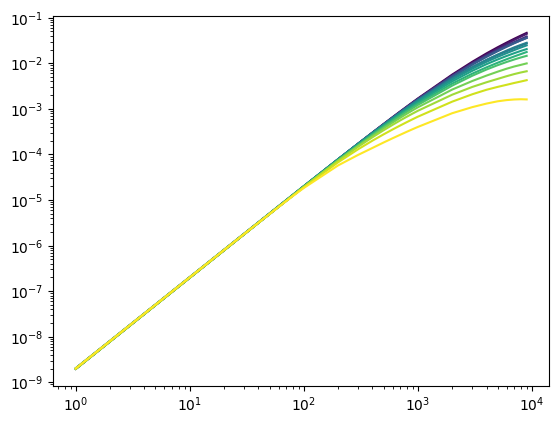

In [14]:
for data in datasets:
    plt.plot(data.t, data.msd, c=cmap(norm(np.mean(data.init.packing_fraction))))
plt.xscale('log')
plt.yscale('log')

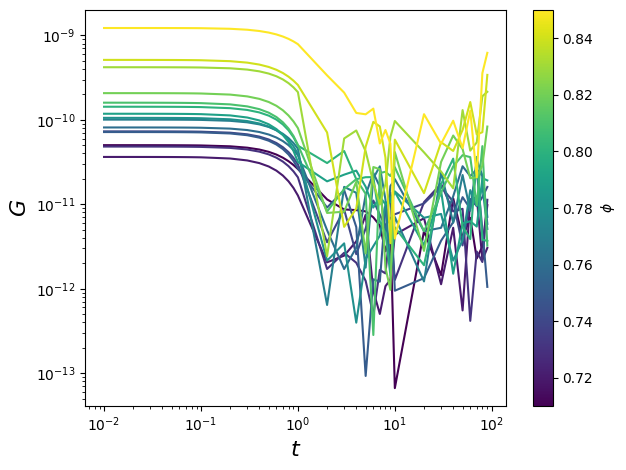

In [18]:
for data in datasets:
    plt.plot(data.t * 1e-2, np.abs(data.shear_modulus), c=cmap(norm(np.mean(data.init.packing_fraction))))
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$G$', fontsize=16)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(packing_fractions)
cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\phi$')
plt.yscale('log')
plt.tight_layout()
# plt.savefig(f'figures/shear_modulus.png', dpi=300)
plt.show()

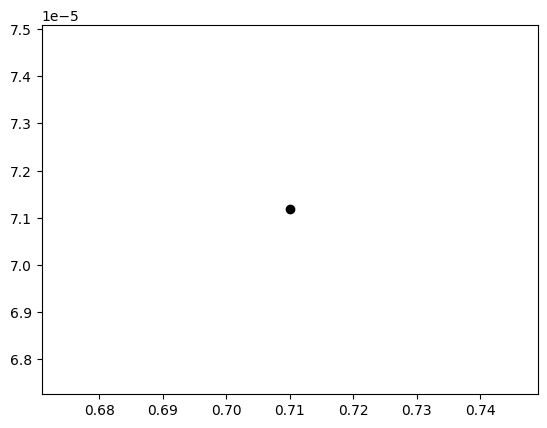

In [76]:
for data in datasets:
    plt.scatter(np.mean(data.init.packing_fraction), np.mean(data.P), c='k')

In [ ]:
desired_frames = 100
steps_to_animate = downsample(datasets[0], desired_frames)

# Define the output path
output_path = "test_disk.gif"

# Create the animation using the downsampled steps
create_animation(
    update_func=draw_particles_frame,
    frames=steps_to_animate,
    filename=output_path,
    fps=15,  # 15 fps for smooth but not too fast animation
    dpi=150,  # Higher resolution
    bitrate=3000,  # Higher bitrate for better quality
    # Keyword arguments passed to draw_particles_frame
    data=datasets[-1],
    system_id=0,
    use_pbc=True,
    which='particle',
    cmap_name='viridis'
)

In [32]:
draw_particles_frame(1, plt.gca(), data, system_id=0, use_pbc=True, which='particle', cmap_name='viridis', location=None)
plt.savefig(f'figures/test_disk.png')
plt.close()

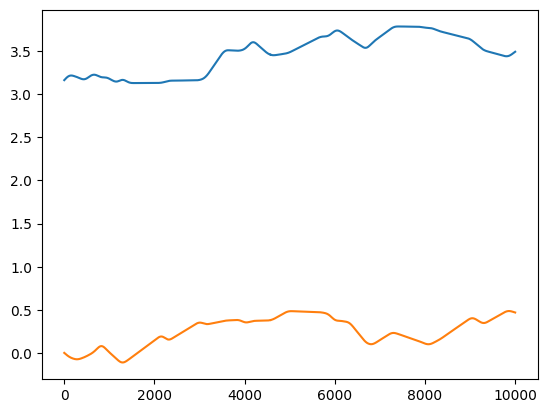

In [41]:
plt.plot(data.trajectory.pos[:, 50, :])